In [ ]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


In [ ]:


%%time

!pip uninstall -q torch -y
!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q -U tokenizers==0.7.0 > /dev/null
!pip install -q -U transformers==3.0.2 > /dev/null
!pip install -q -U simpletransformers==0.46.0 > /dev/null



     |████████████████████████████████| 708.0MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
CPU times: user 1.75 s, sys: 340 ms, total: 2.09 s
Wall time: 2min 52s


In [ ]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


('1.6.0+cu101', '3.0.2', '0.8.1.rc1')

In [ ]:


movies_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LTP/wiki_movie_plots_deduped.csv")
movies_df



,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
...,...,...,...,...,...,...,...,...
34881,2014,The Water Diviner,Turkish,Director: Russell Crowe,Director: Russell Crowe\r\nCast: Russell Crowe...,unknown,https://en.wikipedia.org/wiki/The_Water_Diviner,"The film begins in 1919, just after World War ..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


In [ ]:
movies_df = movies_df[(movies_df["Origin/Ethnicity"]=="American") | (movies_df["Origin/Ethnicity"]=="British")]
movies_df = movies_df[["Plot", "Genre"]]
drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
movies_df.drop(drop_indices, inplace=True)

# Combine genres: 1) "sci-fi" with "science fiction" &  2) "romantic comedy" with "romance"
movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

# Choosing movie genres based on their frequency
shortlisted_genres = movies_df["Genre"].value_counts().reset_index(name="count").query("count > 200")["index"].tolist()
movies_df = movies_df[movies_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

# Shuffle DataFrame
movies_df = movies_df.sample(frac=1).reset_index(drop=True)

# Sample roughly equal number of movie plots from different genres (to reduce class imbalance issues)
movies_df = movies_df.groupby("Genre").head(400).reset_index(drop=True)

label_encoder = LabelEncoder()
movies_df["genre_encoded"] = label_encoder.fit_transform(movies_df["Genre"].tolist())

movies_df = movies_df[["Plot", "Genre", "genre_encoded"]]
movies_df

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Plot,Genre,genre_encoded
0,"In Depression-era Los Angeles, Guy Gabaldon ge...",war,14
1,"Professor Jonathan Venkenheim, interviewed by ...",horror,8
2,"Max Washington (Gregory Hines), just released ...",drama,6
3,"When test results get mixed up, multi-milliona...",romance,11
4,Allen (Imperioli) is a struggling artist who h...,drama,6
...,...,...,...
5933,David Cummins (Kent Smith) is trapped in a dry...,film noir,7
5934,Spike and Tyke walk into the backyard to have ...,animation,2
5935,In the final stages of the Bosnian War in Dece...,war,14
5936,"Johnny Damico (Broderick Crawford), a detectiv...",film noir,7


In [ ]:


%%time

from simpletransformers.classification import ClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 15,
}

# Create a ClassificationModel
#model = ClassificationModel('bert', 'bert-base-uncased', num_labels=len(shortlisted_genres), args=model_args)
model = ClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=len(shortlisted_genres), args=model_args)
#model = ClassificationModel("longformer", "allenai/longformer-base-4096", num_labels=len(cast_counts), args=model_args)
#model = ClassificationModel('roberta', 'roberta-base', num_labels=len(cast_counts), args=model_args)


INFO:filelock:Lock 139950175363728 acquired on /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494.lock


INFO:filelock:Lock 139950175363728 released on /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494.lock


INFO:filelock:Lock 139950380067408 acquired on /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b2b8c7d.lock


INFO:filelock:Lock 139950380067408 released on /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b2b8c7d.lock


- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 6.32 s, sys: 1.05 s, total: 7.37 s
Wall time: 11.4 s


In [ ]:


%%time

train_df, eval_df = train_test_split(movies_df, test_size=0.2, stratify=movies_df["Genre"], random_state=42)

# Train the model
model.train_model(train_df[["Plot", "genre_encoded"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["Plot", "genre_encoded"]])
print(result)



INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48f97fa440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48f97fa440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeo

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48f97fa440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.45696019603970445, 'eval_loss': 3.398180854900571}



{'mcc': 0.45696019603970445, 'eval_loss': 3.398180854900571}
CPU times: user 24min 41s, sys: 13 s, total: 24min 54s
Wall time: 26min 30s


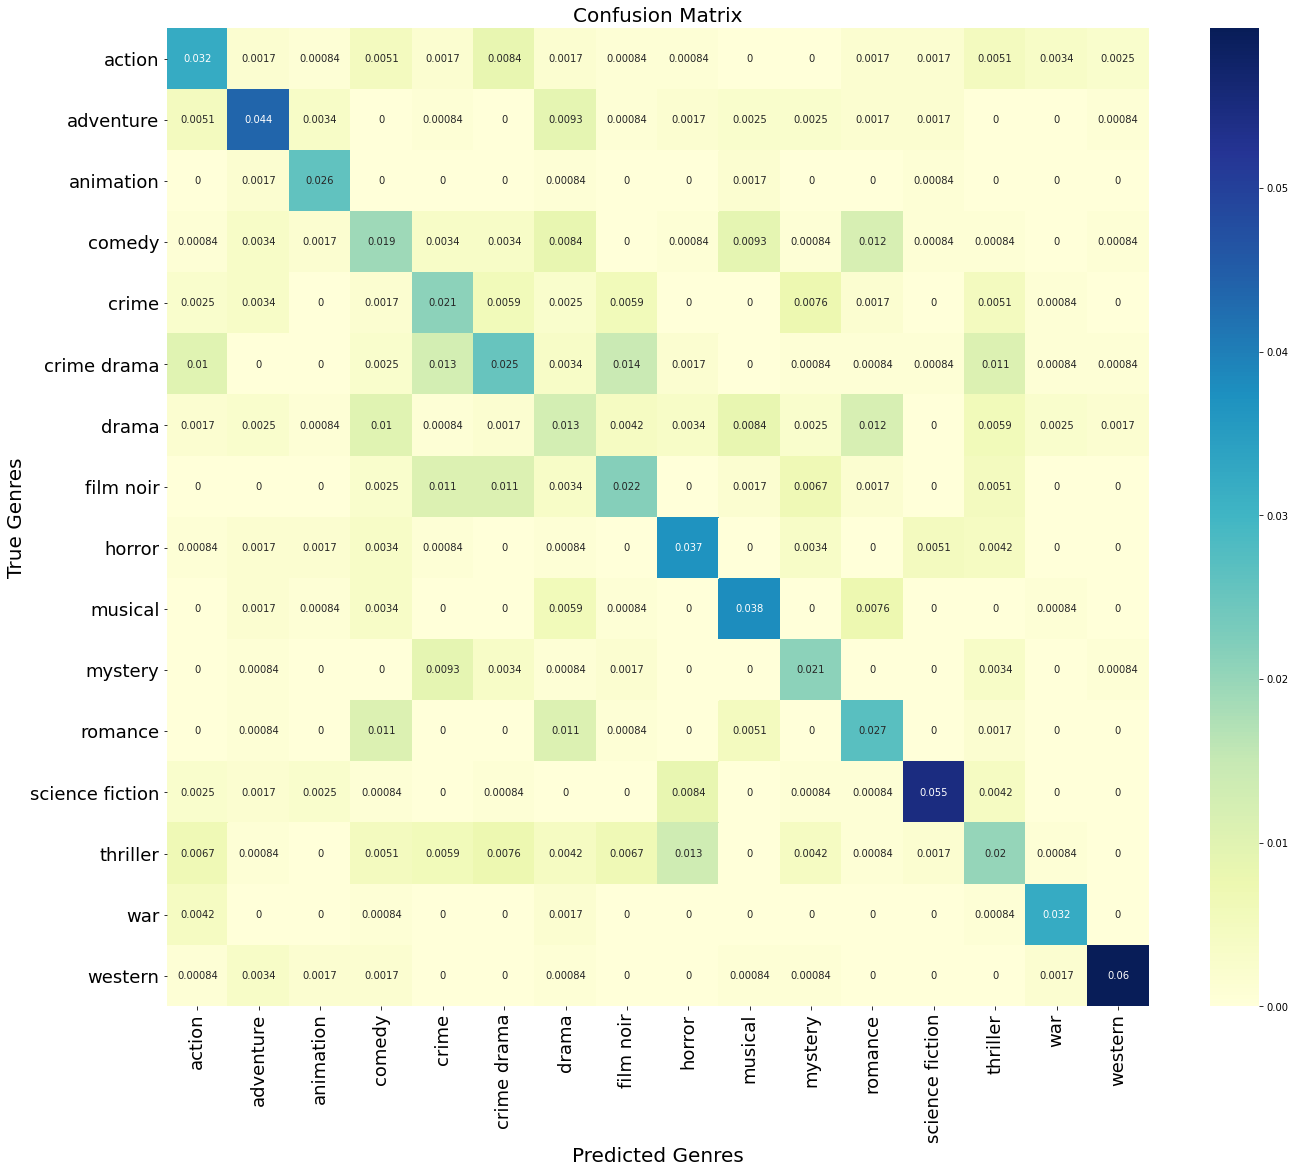

In [ ]:
predicted_genres_encoded = list(map(lambda x: np.argmax(x), model_outputs))
predicted_genres = list(label_encoder.inverse_transform(predicted_genres_encoded))
eval_gt_labels = eval_df["Genre"].tolist()
class_labels = list(label_encoder.classes_)

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels, class_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted Genres', fontsize=20)
ax.set_ylabel('True Genres', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()


In [ ]:
for _ in range(10):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['Plot']
    true_genre = eval_df.iloc[random_idx]['Genre']

    # Predict with trained multiclass classification model
    predicted_genre_encoded, raw_outputs = model.predict([text])
    predicted_genre_encoded = np.array(predicted_genre_encoded)
    predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

    print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
    print(f'Predicted Genre: {predicted_genre}\n')
    print(f'Plot: {text}\n')
    print("-------------------------------------------")


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     mystery

Predicted Genre: crime

Plot: As described in a film magazine,[4] a jeweled garter with an interesting history disappears under mysterious circumstances from the British Museum. The Hawk, a criminal who has never been apprehended even though he obligingly leaves many clues for the police to follow, is suspected. Helen Hamilton (Breamer), daughter of a wealthy American, loses her jewels after throwing them out of a window at Keats Gaunt (Craig), a poet she imagines she is in love with. A tiff with Gaunt follows and she dives into the sea, being rescued by a strange gentleman in a yacht who gives his name as Bruce Calhoun (Standing). English detectives suspect him of the robbery and watch him closely. He goes to Helen's home and becomes acquainted with her family, but his mysterious actions raise doubts in the minds of all save Helen, who now loves him. Not even to her, however, will he admit his part in the mysterious proceedings that are occurring continuousl

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     western

Predicted Genre: drama

Plot: Josephine Monaghan (Amis) is a young society woman who is seduced by her family's portrait photographer, and as a result, bears an illegitimate child. She is expelled from her family and home in disgrace, and with no other resources, she leaves her newborn son under the care of her sister and heads West.
On the road, Josephine discovers that her options are very limited. As a single woman traveling alone, she is viewed with suspicion, or as sexual prey for any man. She assists a traveling salesman (René Auberjonois) who subsequently tries to sell her services as a whore to passing strangers. Seeing it as her only protection, Josephine scars her face, and begins to dress as a man – thus becoming "Jo."
At a mining camp in Ruby City, she meets Percy (McKellen) who takes her under his wing. Percy recommends Jo for a job at the stable, and teaches her about how to survive in the frontier. But Percy nurses a deep suspicion of women, vi



True Genre:     science fiction

Predicted Genre: science fiction

Plot: A futuristic resort, Vice, offers visitors the opportunity to live out all their fantasies, no matter how violent or deviant, on human-like androids (referred to as "artificials"). Every day, the androids' memories are reset, and any damage sustained is scheduled for repair. To maintain the illusion that the androids are real, they are programmed to have emotions and believe themselves to be human. Kelly, an android bartender, believes herself to be on the last day of her job. After meeting Evan, a friendly visitor who encourages her to follow her dreams, she and her friend Melissa, also an android, are brutally killed by a different visitor. At the same time, Detective Roy Tedeschi arrests a rapist at the resort as he sexually assaults one of the androids. Tedeschi's captain orders him to stay away from Vice and only arrest its patrons after they leave, as Vice provides massive tax revenue for the city. Tedesch

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     thriller

Predicted Genre: romance

Plot: Two sisters, Violet and Grace, live a sheltered life within a secluded New England mansion, inherited from their parents. Their father abused them during their childhood throughout the film, believing that they were "gifted" and home-schooling them whilst practically forcing them to complete recreational activities, such as painting and playing musical instruments, and hurting them either physically or mentally if he was not pleased with their effort. Because of their gloomy childhood, the two sisters have formed a strong bond and are incredibly close, however have also lost touch with reality and often come up with "evil" schemes together, their most recent being to lure a young traveller, whom Violet encounters in a bar, into their home and seduce him. It is never revealed why they have chosen to do this, however it is suggested that the sisters, especially Grace, want a baby to raise together.
Violet catches the eye of the 

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     comedy

Predicted Genre: comedy

Plot: Sam Sotto is a Hollywood actor who is known as "king of voice-overs" for his extensive narration and voice-over work. He has recently published an autobiography and is about to receive a lifetime achievement award upon turning 60. His 31-year-old daughter, Carol Solomon, is a struggling vocal coach who has always been overshadowed by her father. Sam forces Carol to move out of his house so that he can live with his girlfriend Jamie, who is a year younger than Carol. Carol leaves to stay with her older sister Dani and her husband Moe.
An upcoming film series, The Amazon Games, plans to bring back the "In a world..." line made famous by the late Don LaFontaine. The trailer voice-over is highly sought after. Sam bows out so that his friend and heir-apparent, Gustav Warner, can assume the role, but Gustav develops laryngitis and fails to show up to a temp track recording. Carol happens to be at the studio doing other work with engine

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     science fiction

Predicted Genre: science fiction

Plot: The story is set in an alternative year 2007. After the fall of Communism, Eastern Europe has descended into anarchy. Out of the chaos comes a mysterious virus that eventually kills everyone who is exposed to it. The virus eventually reaches the United States through Boston, and the city is quarantined. A wall is built, cutting Boston off from the "mainland." All foreign immigrants are barred from entering the US since they may be carriers of the virus. The only people allowed out of the city are those with special passports, only available to those working with a government agency or through the black market.
Officer Delon (Henstridge) is a mother who desperately needs to get away from the quarantined city. She is about to give her son a black-market passport to the safe-zone when she is called in to duty.
A gang has been slaughtered by some kind of creature and the police are investigating. The monster has sup

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     western

Predicted Genre: western

Plot: Howard Nightingale (Kirk Douglas), a U.S. marshal, leads an elite uniformed posse to track down and capture the infamous train robber Jack Strawhorn (Bruce Dern), in an effort to further his political career when running for United States Senator. Strawhorn disrupts his plans when he kidnaps Nightingale. He demands a ransom of $40,000 from the posse for Nightingale's safe return—the same amount of money that the posse burned when tracking Strawhorn down and killing his gang. In order to raise the money, Nightingale's posse have to rob the town, thus turning the public against Nightingale.

-------------------------------------------


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     western

Predicted Genre: western

Plot: Conflict between Ottawa Native Americans, led by Chief Pontiac, and the British.

-------------------------------------------


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.




True Genre:     drama

Predicted Genre: drama

Plot: Jamal and Enayatullah are Afghan refugees in a camp in Peshawar, Pakistan. They travel to Quetta, and thence to Taftan on the Iranian border. They pay people smugglers to assist them over the border; on their first attempt they are stopped by Iranian police and returned to Pakistan, but their second attempt is successful. They travel to Tehran and then to Maku, in the Kurdish part of Iran, from where they cross a mountain range on foot to Turkey. In Istanbul they meet a group of other migrants, and they are taken to Italy inside a shipping container. The container is not ventilated, and most of the refugees, including Enayatullah, are suffocated to death. Jamal survives and lives in Italy for a time. He then steals a woman's purse and buys a rail ticket to Paris. From there, he goes to the Sangatte asylum seekers camp and with a new friend, Yusef, he crosses the English Channel by stowing away on a lorry. Finally, he arrives in Lon



True Genre:     drama

Predicted Genre: comedy

Plot: Jeckie Farnish (Calvert) has grown up in a grindingly poor household, and as she reaches adulthood she resolves to do whatever is necessary to claw her way out of poverty. She is loved by her childhood playmate Joe Bartle (John McCallum), but takes him for granted and feels that he lacks the spark or ambition to match her determination to make something of herself. Instead she pursues Albert Grice (Hubert Gregg), son of a wealthy grocery store owner, and believes they have an understanding. She is horrified when Albert goes on holiday, and returns newly married to another woman.
Seeing a possible payday as compensation for her disappointment, Jeckie sues Albert for breach of promise and emotional distress, and after she plays up her status as jilted victim in court she is awarded a considerable sum in damages. Seeing the chance for revenge, she uses her windfall to set up her own grocery store, directly opposite that of the Grice 

In [ ]:
num = 0
den = 0
for i in range(len(eval_gt_labels)):
  if predicted_genres[i] == eval_gt_labels[i]:
    num += 1
  den += 1

print(num/den)

0.49158249158249157
